In [30]:
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from src.nn.regression_dataset import RegressionDataset
from src.nn.to_tensor import ToTensor
from src.nn.create_data_loaders import create_data_loaders
from src.nn.cnn_regressor import CNNRegressor
from src.nn.plot_losses import plot_losses
from src.nn.get_all_predictions import get_all_predictions
import src.ctes.num_ctes as nctes
import src.ctes.str_ctes as sctes
import src.ctes.path_ctes as pctes

In [31]:
data_path = pctes.DATAPATH
timestamp = "2024_01_03__02_23_39"
hyperparams_path = f"../../data/hyperparams_{timestamp}.npz"
model_path = f"../../data/model_{timestamp}.pt"
losses_path = f"../../data/losses_{timestamp}.npz"
losses_img_path = f"../../data/losses_{timestamp}.png"

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [33]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../data/hyperparams_2024_01_03__02_23_39.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [34]:
print(f"{int(hyperparams[sctes.LEN]) = }")
print(f"{float(hyperparams[sctes.TEST_SIZE]) = }")
print(f"{int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE]) = }")
print(f"{float(hyperparams[sctes.VALID_SIZE]) = }")
print(f"{int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE]) = }")
print(f"{int(hyperparams[sctes.EPOCHS]) = }")
print(f"{int(hyperparams[sctes.BATCH_SIZE]) = }")
print(f"{''.join(hyperparams[sctes.CRITERION].tolist()) = }")
print(f"{''.join(hyperparams[sctes.OPTIMIZER].tolist()) = }")
print(f"{float(hyperparams[sctes.LR]) = }")
print(f"{int(hyperparams[sctes.SEED]) = }")

int(hyperparams[sctes.LEN]) = 12800
float(hyperparams[sctes.TEST_SIZE]) = 0.2
int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE]) = 2560
float(hyperparams[sctes.VALID_SIZE]) = 0.2
int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE]) = 2048
int(hyperparams[sctes.EPOCHS]) = 3
int(hyperparams[sctes.BATCH_SIZE]) = 6
''.join(hyperparams[sctes.CRITERION].tolist()) = 'MSELoss()'
''.join(hyperparams[sctes.OPTIMIZER].tolist()) = 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    capturable: False\n    differentiable: False\n    eps: 1e-08\n    foreach: None\n    fused: None\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)'
float(hyperparams[sctes.LR]) = 0.001
int(hyperparams[sctes.SEED]) = 42


In [35]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [36]:
transform = ToTensor()
sample_size = nctes.LEN_SAMPLE

data = RegressionDataset(data_path, transform, sample_size)

In [37]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [38]:
model = CNNRegressor(input_size=sample_size)
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Sequential: 1-2                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-3                         [-1, 32, 16384]           --
├─Sequential: 1-4                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─BatchNorm1d: 2-8                  [-1, 64, 16381]           128
|    └─ReLU: 2-9                         [-1, 64, 16381]           --
├─AvgPoo

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Sequential: 1-2                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-3                         [-1, 32, 16384]           --
├─Sequential: 1-4                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─BatchNorm1d: 2-8                  [-1, 64, 16381]           128
|    └─ReLU: 2-9                         [-1, 64, 16381]           --
├─AvgPoo

In [39]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [40]:
criterion = nn.MSELoss()
print(f"{criterion = }")

criterion = MSELoss()


In [41]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")

Sample length    = 32768
Total samples    = 12800
Train samples    = 8192
Valid samples    = 2048
Test samples     = 2560
Batch size       = 6
Number of epochs = 3
Loss             = MSELoss()
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate    = 0.001
Seed             = 42.0


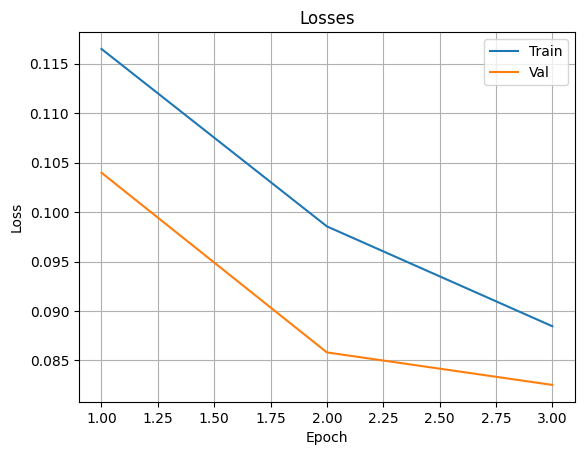

In [42]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])
# plt.savefig(losses_img_path)

In [43]:
targets, preds = get_all_predictions(model, test_loader, device)

100%|██████████| 427/427 [00:16<00:00, 26.31it/s]


In [44]:
test_losses = [] 
for target, pred in tqdm(zip(targets, preds)):
    target = torch.FloatTensor(target).to(device=device)
    pred = torch.FloatTensor(pred).to(device=device)
    test_losses.append(criterion(target, pred).item())
test_losses = np.array(test_losses)

2560it [00:00, 8321.02it/s]


In [45]:
idx_sort    = np.flip(np.argsort(test_losses))
test_losses = test_losses[idx_sort]
targets     = targets[idx_sort]
preds       = preds[idx_sort]

In [46]:
total_test_loss = np.mean(test_losses)
print("Total Test MSE = {:0.4f}".format(total_test_loss))

Total Test MSE = 0.0866


In [47]:
n_show = 10
print(f"{n_show} Worst Results ==>")
for i in range(n_show):
    print(f"                 c1         c2          L       epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[i]]}")
    print(f"MSE         = {'{:0.4f}'.format(test_losses[i])}")
    print()

10 Worst Results ==>
                 c1         c2          L       epsilon
Target      = ['0.0000', '0.0000', '1.0000', '0.0000']
Prediction  = ['0.2240', '0.4419', '0.1578', '0.5130']
MSE         = 0.3045

                 c1         c2          L       epsilon
Target      = ['0.0000', '1.0000', '1.0000', '1.0000']
Prediction  = ['0.2801', '0.4883', '0.3374', '0.4606']
MSE         = 0.2675

                 c1         c2          L       epsilon
Target      = ['0.0000', '0.0000', '1.0000', '0.7500']
Prediction  = ['0.2470', '0.4487', '0.1814', '0.4520']
MSE         = 0.2553

                 c1         c2          L       epsilon
Target      = ['0.0000', '0.3333', '1.0000', '1.0000']
Prediction  = ['0.1956', '0.5747', '0.2723', '0.4009']
MSE         = 0.2463

                 c1         c2          L       epsilon
Target      = ['0.3333', '1.0000', '1.0000', '0.0000']
Prediction  = ['0.6243', '0.5232', '0.4003', '0.5479']
MSE         = 0.2430

                 c1         c2         

In [48]:
n_show = 10
print(f"{n_show} Best Results ==>")
for i in range(n_show, 0, -1):
    print(f"                 c1         c2          L       epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[-i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[-i]]}")
    print(f"WeightedMSE = {'{:0.4f}'.format(test_losses[-i])}")
    print()

10 Best Results ==>
                 c1         c2          L       epsilon
Target      = ['0.6667', '0.6667', '0.2500', '0.5000']
Prediction  = ['0.7334', '0.5720', '0.3451', '0.4915']
WeightedMSE = 0.0056

                 c1         c2          L       epsilon
Target      = ['0.6667', '0.6667', '0.7500', '0.5000']
Prediction  = ['0.6827', '0.5409', '0.8230', '0.5202']
WeightedMSE = 0.0055

                 c1         c2          L       epsilon
Target      = ['1.0000', '0.6667', '0.2500', '0.5000']
Prediction  = ['0.9764', '0.5381', '0.2491', '0.4387']
WeightedMSE = 0.0052

                 c1         c2          L       epsilon
Target      = ['0.3333', '0.6667', '0.5000', '0.5000']
Prediction  = ['0.2798', '0.5607', '0.5563', '0.4420']
WeightedMSE = 0.0052

                 c1         c2          L       epsilon
Target      = ['0.3333', '0.3333', '0.5000', '0.5000']
Prediction  = ['0.3501', '0.4237', '0.5922', '0.4489']
WeightedMSE = 0.0049

                 c1         c2          

In [49]:
# ToDo
 
# On cnn_base.py : 
# Change Flatten layer by some ConvTranspose1d before the linear dense layer